# NARMA10
## Univariate Time Series Forecasting: 
#### Device: Emucore

Time series forecasting is a crucial task in various fields, including finance, weather prediction, and signal processing. Accurate predictions of future values can enable better decision-making and planning. In recent years, machine learning techniques, such as reservoir computing, have shown promising results in addressing this challenge.

In this example, we explore time series forecasting using reservoir computing to predict the Nonlinear AutoRegressive Moving Average (NARMA) 10 time series. NARMA 10 is a synthetic time series generator that mimics the behavior of real-world processes by generating nonlinear and chaotic patterns. Reservoir computing, on the other hand, is a powerful machine learning framework that leverages the dynamics of a large dynamical system, known as a reservoir, to perform tasks like time series prediction.

In thise example, we aim to demonstrate the effectiveness of reservoir computing in forecasting NARMA 10 time series data. We will utilize emucore to generate the reservoir computing model, train it on historical NARMA 10 data, and evaluate its performance in predicting future values. By comparing the predictions with ground truth data, we can assess the accuracy and reliability of the model.

The notebook is organized as follows:

- ***Reservoir computing with Emucore***: Provides a brief introduction to reservoir computing
- ***Create NARMA10 time series***: We generate synthetic NARMA 10 time series data to serve as our training and testing dataset.
- ***Model data using reservoir***: We will be utilzing QCi's photonic reservoir emulator EmuCore.
- ***Train prediction model***: We'll be using a simple linear regressor to obtain predictions from the reservoir output.
- ***Evaluate predictions***: We evaluate the performance of the trained model on the testing data using Normalized Root Mean Squared Error (NRMSE). Beyond this we will also visualize the accuracy using a few different plots.

## Reservoir computing with EmuCore

EmuCore, developed by QCi, represents a cutting-edge electronic reservoir computing platform designed specifically for tackling complex time series forecasting tasks. EmuCore harnesses the principles of reservoir computing, a powerful machine learning paradigm inspired by the brain's dynamics, to efficiently process and predict time-dependent data. At the heart of EmuCore lies a large-scale dynamical system, referred to as the reservoir, composed of interconnected electronic components. These components exhibit rich nonlinear and chaotic dynamics, enabling EmuCore to capture and extract intricate patterns and dependencies present in time series data. The reservoir maps input signals from their original values to a higher dimensional feature space. Through the integration of advanced hardware design, innovative algorithms, and rigorous testing, EmuCore represents a groundbreaking solution for time series forecasting and other machine learning tasks. Its versatility, performance, and efficiency make it a valuable tool for researchers, engineers, and practitioners seeking to make accurate predictions on time series tasks utilizing a time delayed reservoir architecture. For more information on QCi's reservoir architecture see this paper from QCI at <https://arxiv.org/pdf/2102.09049.pdf>

![RNN Reservoir Schematic](figures/03.svg)
![Time Delayed Reservoir Schematic](figures/04.svg)
<figcaption>Figure 1: (a) Conventional reservoir computing (RC) model and (b) time-delay based RC model.</figcaption>

<h2 id="narma10_data_gen">Create NARMA10 time series</h2>

In order to illustrate the capabilities of EmuCore we will utilze a common forecasting benchmark NARMA10:

> $y_{k+1} = 0.3 y_k + 0.05 y_k \sum_{𝑖=0}^{9} y_{k-i} + 1.5 u_k u_{k−9} + 0.1$

where the input $u_k$ is drawn from a uniform distribution in the interval $[0, 0.5]$.
The function below generates a NARMA10 time series and splits it into training and testing parts.

In [1]:
import numpy as np

def NARMA10(seed, train_size, test_size):    
    np.random.seed(seed)
    total_size = train_size + test_size
    utrain = 0.5 * np.random.rand(total_size, 1)
    ytrain = np.zeros((10, 1))
    for i in list(range(9, total_size - 1)):
        temp = (
            0.3 * ytrain[i]
            + 0.05 * ytrain[i] * np.sum(ytrain[i - 10 + 1 : i + 1])
            + 1.5 * utrain[i] * utrain[i - 10 + 1]
            + 0.1
        )
        ytrain = np.append(ytrain, [temp], axis=0)

    train_data = {
        "trainInput": utrain[0:train_size],
        "trainTarget": ytrain[0:train_size],
    }

    test_data = {
        "testInput": utrain[train_size:total_size],
        "testTarget": ytrain[train_size:total_size],
    }

    dataset = {"train_data": train_data, "test_data": test_data}    
    return dataset

Let us consider a NARMA10 series of size 1000 with 800 samples in the training portion and 200 in the testing portion.

In [2]:
TRAIN_SIZE = 800
TEST_SIZE = 200

dataset = NARMA10(seed=0, train_size=TRAIN_SIZE, test_size=TEST_SIZE)

X_train = dataset["train_data"]["trainInput"]
y_train = dataset["train_data"]["trainTarget"].reshape((TRAIN_SIZE))

X_test = dataset["test_data"]["testInput"]
y_test = dataset["test_data"]["testTarget"].reshape((TEST_SIZE))

The target for this forecast is plotted below with the training portion in blue and the testing portion in red:

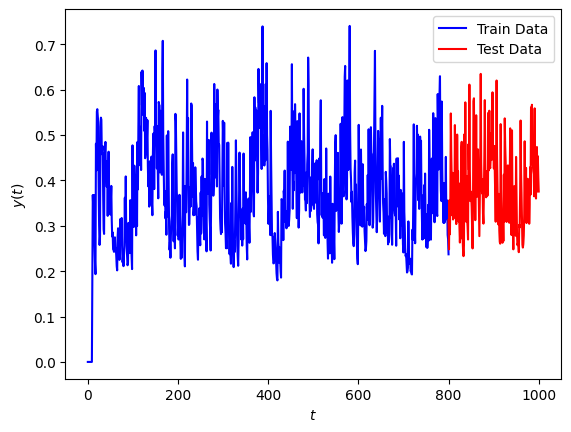

In [3]:
import matplotlib.pyplot as plt

t_train = np.linspace(0, TRAIN_SIZE, TRAIN_SIZE)
t_test = np.linspace(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE, TEST_SIZE)

plt.plot(t_train, y_train, "b")
plt.plot(t_test, y_test, "r")
plt.legend(["Train Data", "Test Data"])
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.show()

## Modelling data using reservoir

After filling out some necessary details including replacing the IP_ADDR and PORT variables with our specific hardware destination we can begin interacting with the device through the client interface. Utilizing EmuCore's direct interface we first begin by acquiring the lock. This ensures that the device is not being utilized by other users or processes and ensures that no one other than the current user can manipulate the reservoir anyway. Some of the ways we can interact with the hardware include resetting the reservoir and configuring reservoir size and attributes.

In [4]:
from emucore_direct.client import EmuCoreClient
from time import time

IP_ADDR = "YOUR_DEVICE_IP_ADDRESS"
PORT = "YOUR_DEVICE_PORT"
# Instantiate an EmuCore instance
ec_client = EmuCoreClient(ip_addr=IP_ADDR, port = PORT)

The first step to begin interacting with the device is to acquire the device lock:

In [5]:
# A a lock id and reset the device
lock_id, start, end = ec_client.wait_for_lock()

The above function will wait indefinitely until the device lock is avaialble. After acquiring the device execution lock, the reservoir can be configured to a specific model and used to generated data utilizing the specified model on time series data.
The following parameters can be configured to customize the reservoir model:
<ul>
    <li><strong>vbias:</strong> bias to apply to each node in reservoir range for parameter [0,1]. </li> 
    <li><strong>gain:</strong> memory setting for system how long should inputs effect reservoir similar to beta in adaptive gradient descent range for parameter [0,1]. </li>
    <li><strong>num_nodes:</strong> the total number of hidden nodes to instantiate within the reservoir, a single hidden layer.</li>
    <li><strong>num_taps:</strong> number of connections in reservoir, generally should be set to less than the number of nodes in reservoir. Defines interconnection between nodes. </li>
</ul>

In [6]:
VBIAS = 0.31
GAIN = 0.72
NUM_NODES = 400
NUM_TAPS = 400
# A a lock id and reset the device
#lock_id, start, end = client.wait_for_lock()
print("Reservoir reset")
ec_client.reservoir_reset(lock_id=lock_id)
print("Reservoir config")
# Configure
ec_client.rc_config(
    lock_id=lock_id,
    vbias=VBIAS,
    gain=GAIN,
    num_nodes=NUM_NODES,
    num_taps=NUM_TAPS
)

Reservoir reset
Reservoir config


{'status': 0, 'message': ''}

Once the reservoir is configured data can be transformed using the reservoir model. 

In [7]:
FEATURE_SCALING = 0.1
DENSITY = 1.0

resp_train, train_max_scale_val, train_wgts = ec_client.process_all_data(
    input_data=X_train,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
    seed_val_weights = 10,
    max_scale_val=None,
)

resp_test, test_max_scale_val, test_wgts = ec_client.process_all_data(
    input_data=X_test,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
    seed_val_weights = 10,
    max_scale_val=train_max_scale_val,
)

Once finished processing it is important to release the lock so that other users can access the reservoir computer which is what the below command accomplishes:

In [8]:
ec_client.release_lock(lock_id=lock_id)

{'status': 0, 'message': 'Success'}

Each reservoir node produces a response based on the input signal that retains some information from previous data points allowing for accurate predictions. The plot below shows the reservoir node values at each time step in the testing set:

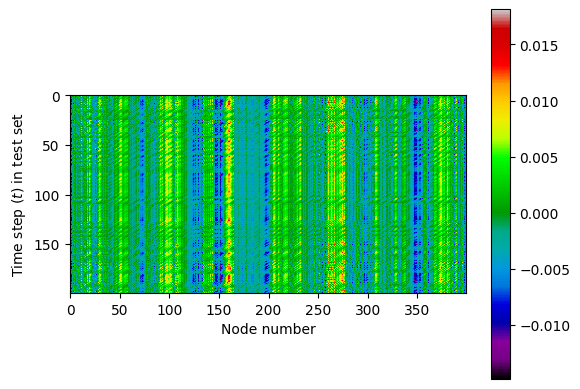

In [9]:
plt.figure()
plt.imshow(resp_test, cmap="nipy_spectral")
plt.xlabel("Node number")
plt.ylabel("Time step ($t$) in test set")
plt.colorbar()
plt.show()

## Train prediction model

Once we have the reservoir response, we can build a simple linear regression model using the reservoir response as its input. Utilzing a reservoir allows for simpler models to obtain higher accuracy than is possible without this data augmentation approach:

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression()
lin_model.fit(resp_train, y_train)

y_pred_train = lin_model.predict(resp_train)
y_pred_test = lin_model.predict(resp_test)

## Evaluate predictions
We will utilize three metrics to analyze the quality of the model and to check for overfitting to the training data $NRMSE$, $MSE$, and $R^2$. $NRMSE$ will be calculated as shown below:
$NRMSE = \sqrt{\frac{1}{m} \sum_{k=0}^{m}\frac{(\hat{y}_k - y_k)^2}{\sigma^2(y)}}$

In [11]:
def NRMSE(target, estimate):
    return np.sqrt(((estimate - target) ** 2).mean()) / np.std(target)

In [12]:

# Calculate Mean Squared Error and R-squared
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Train Mean Squared Error: {mse_train:.4f}")
print(f"Train R-squared: {r2_train:.2f}")

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.2f}")
print("Train NRMSE:", NRMSE(y_train, y_pred_train))
print("Test NRMSE:", NRMSE(y_test, y_pred_test))

Train Mean Squared Error: 0.0001
Train R-squared: 0.99
Test Mean Squared Error: 0.0003
Test R-squared: 0.96
Train NRMSE: 0.09582885843850779
Test NRMSE: 0.19772048772699802


Finally, the overall performance can be observed by looking at a plot of the residuals and the target value vs the predicted value from our linear model that was trained above.

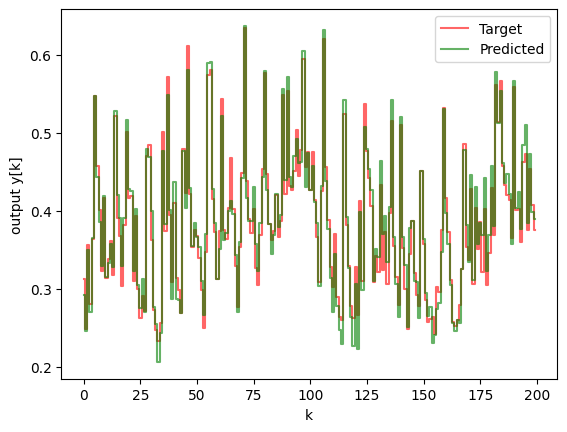

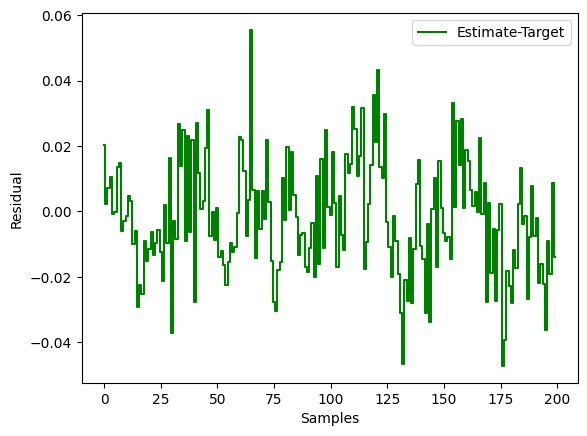

In [13]:
def StepPlotData(y1,y2,legend1="y1",legend2="y2"):
    
    plt.figure()
    assert(y1.shape[0]==y2.shape[0])
    i=np.arange(y1.shape[0])
    plt.step(i,y1,'r', where='mid', label=legend1,alpha=0.6)
    plt.legend()
    plt.step(i,y2,'g', where='mid', label=legend2,alpha=0.6)
    plt.legend()

StepPlotData(y1=y_test, y2=y_pred_test, legend1="Target", legend2="Predicted")
plt.xlabel("k")
plt.ylabel("output y[k]")

plt.figure()
plt.step(y_test-y_pred_test,'g', where='mid', label="Estimate-Target")
plt.legend()

plt.xlabel("Samples")
plt.ylabel("Residual")
plt.show()